In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Data
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")


In [3]:
# Combine datasets for uniform preprocessing
data = pd.concat([train_df, test_df], sort=False)

In [4]:
# ----------------------- EDA -----------------------
print("Missing values:\n", data.isnull().sum())

Missing values:
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


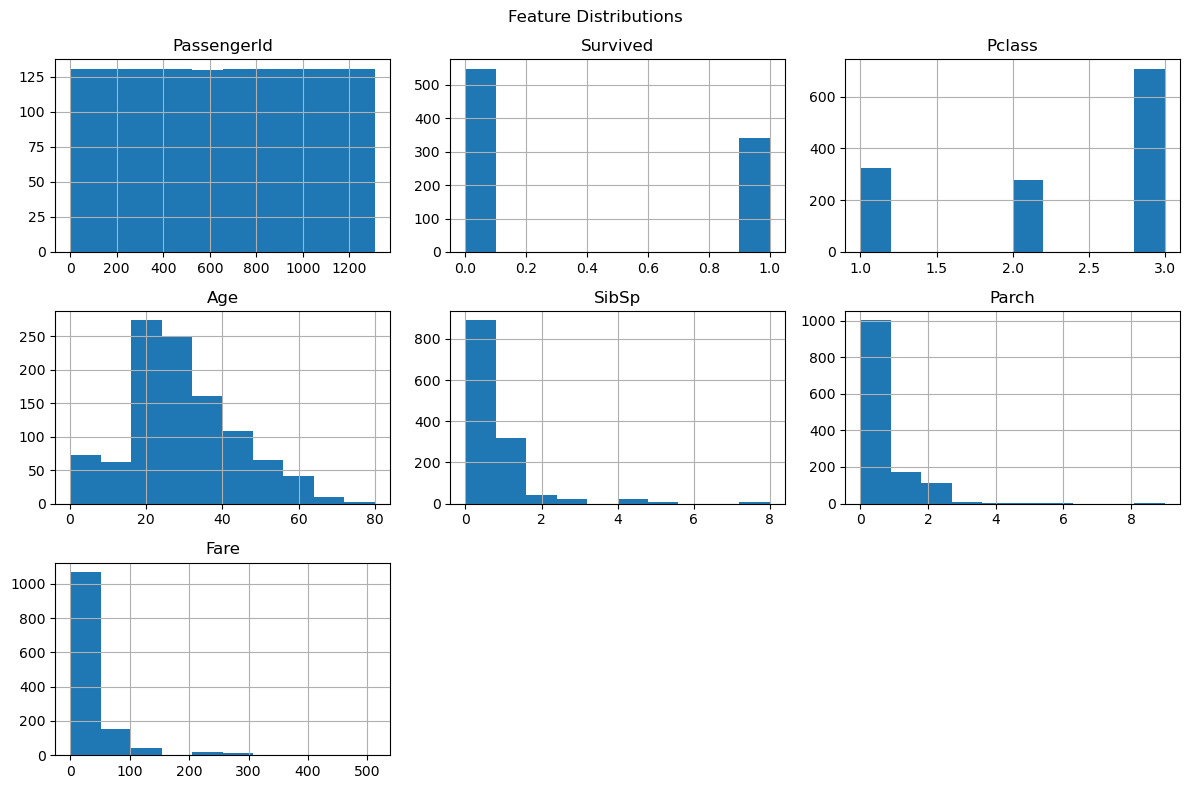

In [5]:
# Histograms
data.hist(figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

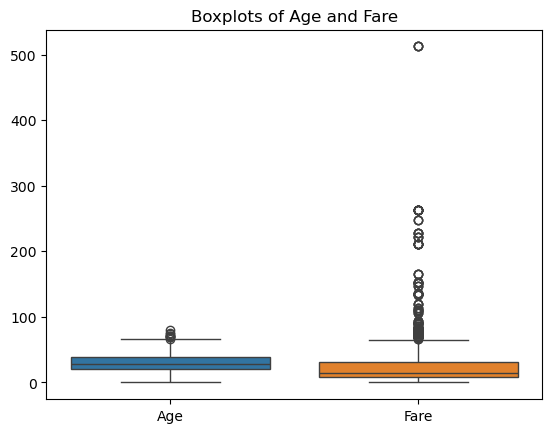

In [7]:
sns.boxplot(data=data[num_features])
plt.title("Boxplots of Age and Fare")
plt.show()


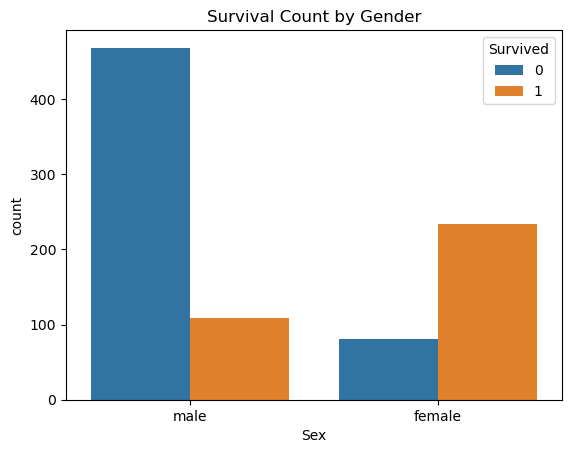

In [8]:
# Barplot: Survival vs Sex
sns.countplot(data=train_df, x='Sex', hue='Survived')
plt.title("Survival Count by Gender")
plt.show()

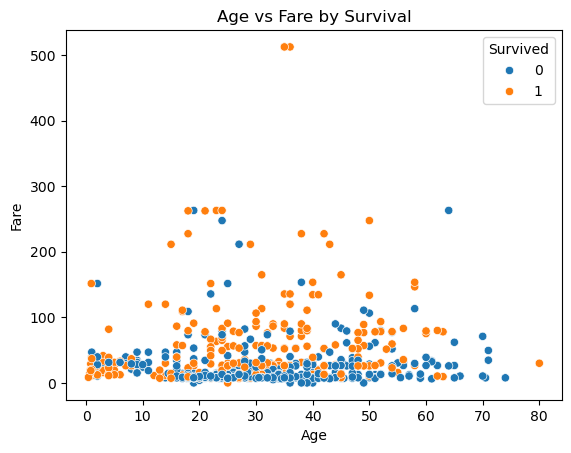

In [9]:
# Scatterplot: Age vs Fare colored by Survival
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived')
plt.title("Age vs Fare by Survival")
plt.show()


In [10]:
# ------------------- Data Preprocessing -------------------
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

In [11]:
# Drop unnecessary columns
data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)

In [12]:
# Encode categorical features
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'])

In [13]:
# Separate back
train_cleaned = data[:len(train_df)]
test_cleaned = data[len(train_df):]


In [14]:
# Define features and target
X = train_cleaned.drop("Survived", axis=1)
y = train_cleaned["Survived"]

In [15]:
# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# ------------------- LightGBM Model -------------------
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [17]:
# ------------------- XGBoost Model -------------------
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [18]:
# ------------------- Evaluation -------------------
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

evaluate_model(y_test, lgb_preds, "LightGBM")
evaluate_model(y_test, xgb_preds, "XGBoost")



--- LightGBM Evaluation ---
Accuracy: 0.8212290502793296
Precision: 0.7837837837837838
Recall: 0.7837837837837838
F1 Score: 0.7837837837837838

--- XGBoost Evaluation ---
Accuracy: 0.7988826815642458
Precision: 0.7567567567567568
Recall: 0.7567567567567568
F1 Score: 0.7567567567567568


In [19]:
# ------------------- Visualization of Comparison -------------------
metrics = {
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, lgb_preds), accuracy_score(y_test, xgb_preds)],
    "Precision": [precision_score(y_test, lgb_preds), precision_score(y_test, xgb_preds)],
    "Recall": [recall_score(y_test, lgb_preds), recall_score(y_test, xgb_preds)],
    "F1 Score": [f1_score(y_test, lgb_preds), f1_score(y_test, xgb_preds)]
}


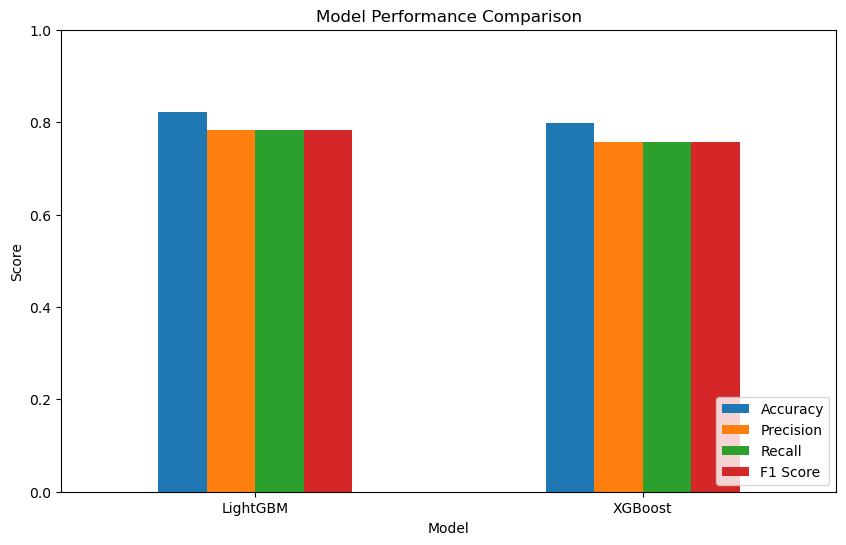

In [20]:
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()